### Bibliotecas

In [1]:
import pandas as pd
import geopandas as gpd

### Localização dos arquivos

In [17]:
arquivo_cge = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Alagamentos_CGESP/Alagamentos_SP_2015.csv'

arquivo_incidentes = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_riscoocorrencia/SIRGAS_SHP_riscoocorrencia_2015.shp'

### Carregamento e validações dos incidentes do Geosampa

In [18]:
gdf_incidentes = gpd.read_file(arquivo_incidentes)

In [19]:
print(gdf_incidentes['ocorrencia'].unique())

['ALAGAMENTO' 'DESLIZAMENTO' 'QUEDA DE ARVORE' 'INUNDACAO']


In [20]:
# Lista de valores que você deseja excluir
valores_excluir = ['QUEDA DE ARVORE', 'DESLIZAMENTO']

# Excluir os valores indesejados diretamente no próprio gdf
gdf_incidentes = gdf_incidentes[~gdf_incidentes['ocorrencia'].isin(valores_excluir)]

# Verifique o resultado
print(gdf_incidentes)

           data  ocorrencia                      subprefeit    name  \
0    2015-12-27  ALAGAMENTO        MP - SAO MIGUEL PAULISTA  180771   
1    2015-12-26  ALAGAMENTO                  PI - PINHEIROS  180651   
2    2015-12-26  ALAGAMENTO        MP - SAO MIGUEL PAULISTA  180582   
3    2015-12-26  ALAGAMENTO  MG - VILA MARIA/VILA GUILHERME  180638   
6    2015-12-26  ALAGAMENTO                  PI - PINHEIROS  180660   
...         ...         ...                             ...     ...   
4742 2015-03-16  ALAGAMENTO         EM - ERMELINO MATARAZZO  127400   
4744 2015-04-15  ALAGAMENTO                   IQ - ITAQUERA  131423   
4751 2015-09-12  ALAGAMENTO                       LA - LAPA  151521   
4755 2015-10-03  ALAGAMENTO                         SE - SE  157235   
4768 2015-12-26  ALAGAMENTO                SA - SANTO AMARO  180657   

                                geometry  
0     POINT Z (357555.511 7401829.917 0)  
1     POINT Z (327909.894 7390916.855 0)  
2      POINT Z (35

In [21]:
gdf_incidentes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1404 entries, 0 to 4768
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        1404 non-null   datetime64[ms]
 1   ocorrencia  1404 non-null   object        
 2   subprefeit  1404 non-null   object        
 3   name        1404 non-null   object        
 4   geometry    1404 non-null   geometry      
dtypes: datetime64[ms](1), geometry(1), object(3)
memory usage: 65.8+ KB


### Carregamento e validações dos dados de alagamento do CGE-SP

In [8]:
import os
import pandas as pd

In [10]:
diretorio_cge = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Alagamentos_CGESP'

In [20]:
def listar_csv(diretorio):
    arquivos_csv = []
    
    # Percorre os arquivos no diretório fornecido
    for arquivo in os.listdir(diretorio):
        # Verifica se o arquivo tem extensão .csv
        if arquivo.endswith(".csv"):
            arquivos_csv.append(arquivo)
            
     # Ordena a lista de arquivos com base nos quatro últimos dígitos (o ano)
    arquivos_csv.sort(key=lambda x: int(x[-8:-4]))  # Captura os quatro últimos dígitos antes da extensão .csv
    
    return arquivos_csv

In [28]:
def processar_csv(diretorio):
    arquivos_csv = listar_csv(diretorio)
    dataframes = []  # Lista para armazenar os DataFrames processados

    for arquivo in arquivos_csv:
        caminho_arquivo = os.path.join(diretorio, arquivo)

        # Carrega o CSV e processa as colunas de Data e Horário
        df_cge = pd.read_csv(caminho_arquivo, sep=';')

        # Convertendo a coluna 'Data' para datetime
        formato_data = '%d/%m/%y'
        df_cge['Data'] = pd.to_datetime(df_cge['Data'], format=formato_data)

        # Convertendo as colunas 'Horário Inicial' e 'Horário Final' para time
        df_cge['Horário Inicial'] = pd.to_datetime(df_cge['Horário Inicial'], format='%H:%M').dt.time
        df_cge['Horário Final'] = pd.to_datetime(df_cge['Horário Final'], format='%H:%M').dt.time

        # Adiciona o DataFrame processado à lista
        dataframes.append(df_cge)

        # Concatena todos os DataFrames em um único DataFrame
        df_final = pd.concat(dataframes, ignore_index=True)
    
    return df_final

In [31]:
# Exemplo de uso
df_cge_processados = processar_csv(diretorio_cge)

In [32]:
# Exemplo para exibir o primeiro DataFrame
print(df_cge_processados.head())

   Unnamed: 0       Data  Alagamento Bairro                 Tipo  \
0           0 2013-01-08           1     Sé  Inativo Transitável   
1           1 2013-01-08           1     Sé  Inativo Transitável   
2           2 2013-01-08           1     Sé  Inativo Transitável   
3           3 2013-01-08           1     Sé  Inativo Transitável   
4           4 2013-01-08           1     Sé  Inativo Transitável   

  Horário Inicial Horário Final                          Endereço Sentido  \
0        19:16:00      22:36:00  VEL PRES ARTHUR DA COSTA E SILVA   AMBOS   
1        19:19:00      21:01:00  VEL PRES ARTHUR DA COSTA E SILVA   AMBOS   
2        19:27:00      20:29:00                   PÇ. DA BANDEIRA     C/B   
3        19:32:00      22:36:00  VEL PRES ARTHUR DA COSTA E SILVA   LA/PE   
4        20:01:00      22:28:00                  AV NOVE DE JULHO     B/C   

                    Referência  
0   AV GAL OLIMPIO DA SILVEIRA  
1                     AL GLETE  
2              RUA SANTO AMAR

In [42]:
# Salvando o DataFrame em um arquivo CSV
df_cge_processados.to_csv('alagamentos_cge_1324.csv', index=True)

### Validações estatísticas no arquivo do CGE-SP

In [33]:
df_cge_processados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9764 entries, 0 to 9763
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       9764 non-null   int64         
 1   Data             9764 non-null   datetime64[ns]
 2   Alagamento       9764 non-null   int64         
 3   Bairro           9764 non-null   object        
 4   Tipo             9764 non-null   object        
 5   Horário Inicial  9764 non-null   object        
 6   Horário Final    9746 non-null   object        
 7   Endereço         9764 non-null   object        
 8   Sentido          9764 non-null   object        
 9   Referência       9764 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 762.9+ KB


In [37]:
# Extraindo o ano da coluna 'Data'
df_cge_processados['Ano'] = df_cge_processados['Data'].dt.year
df_cge_processados['Mês'] = df_cge_processados['Data'].dt.month
    
# Agrupando pelo ano e contando o número de ocorrências
total_por_mes_ano = df_cge_processados.groupby(['Ano', 'Mês']).size()

# Usando unstack para colocar os meses na horizontal
total_por_mes_ano_horizontal = total_por_mes_ano.unstack(fill_value=0)    

print(total_por_mes_ano_horizontal)

Mês    1    2    3    4   5   6   7   8    9    10   11   12
Ano                                                         
2013  114  284  135   22   0  41  14   0   26   37   40   39
2014  152   64  119   20  11   0   0   3   16    1   57  180
2015  158  129  184   30   2   0  38   8  140   43  127  146
2016  142  225  212    3  11  76  13  27   10   48  104  100
2017  275  181   71  112  70  88   0   7    2   15   62   29
2018  107   34  193    8   4   2  21   5   59   54   55   98
2019  190  285  258   85   9  36  64   0   11    7   99  137
2020  276  394   52    0   1  49   6  16    1   94   62  133
2021  168  189  115   16   7   1  12   3    2   26   24   53
2022  179   31  199    4   8   2   0   0   50   26   63  106
2023  145  242  214   45   5   4   0   5   11  116   64   42
2024  173  108   95    5  17   0  11   0    4    6    0    0


### Validações cruzadas entre GeoSampa e CGE-SP

In [25]:
datas_geosampa = gdf_incidentes['data']
datas_cge = df_cge['Data']

In [26]:
# Verificamos se todas as datas do gdf têm correspondência no df
gdf_incidentes['Correspondencia'] = gdf_incidentes['data'].isin(datas_cge)

# Exibe as linhas do gdf que NÃO têm correspondência no df
gdf_sem_correspondencia = gdf_incidentes[gdf_incidentes['Correspondencia'] == False]

# Exibe os resultados
print(gdf_sem_correspondencia)

           data  ocorrencia                subprefeit    name  \
248  2015-12-23  ALAGAMENTO             IQ - ITAQUERA  180014   
358  2015-11-21  ALAGAMENTO          SA - SANTO AMARO  171432   
359  2015-11-21  ALAGAMENTO     ST - SANTANA/TUCURUVI  171424   
438  2015-11-30  ALAGAMENTO                   SE - SE  173089   
521  2015-12-15  ALAGAMENTO            PI - PINHEIROS  178480   
...         ...         ...                       ...     ...   
4465 2015-01-09   INUNDACAO  MP - SAO MIGUEL PAULISTA  114669   
4466 2015-01-09   INUNDACAO  MP - SAO MIGUEL PAULISTA  114671   
4726 2015-02-21   INUNDACAO  MP - SAO MIGUEL PAULISTA  125360   
4732 2015-03-17   INUNDACAO  MP - SAO MIGUEL PAULISTA  129088   
4751 2015-09-12  ALAGAMENTO                 LA - LAPA  151521   

                                geometry  Correspondencia  
248   POINT Z (352530.406 7392334.516 0)            False  
358    POINT Z (327403.11 7385528.319 0)            False  
359   POINT Z (335074.259 7399925.513 0

In [27]:
gdf_sem_correspondencia['data'].unique()

<DatetimeArray>
['2015-12-23 00:00:00', '2015-11-21 00:00:00', '2015-11-30 00:00:00',
 '2015-12-15 00:00:00', '2015-12-17 00:00:00', '2015-11-16 00:00:00',
 '2015-10-01 00:00:00', '2015-09-04 00:00:00', '2015-05-29 00:00:00',
 '2015-05-31 00:00:00', '2015-08-04 00:00:00', '2015-08-18 00:00:00',
 '2015-03-25 00:00:00', '2015-04-07 00:00:00', '2015-04-18 00:00:00',
 '2015-03-17 00:00:00', '2015-03-18 00:00:00', '2015-02-27 00:00:00',
 '2015-03-02 00:00:00', '2015-02-21 00:00:00', '2015-02-22 00:00:00',
 '2015-02-26 00:00:00', '2015-02-20 00:00:00', '2015-02-19 00:00:00',
 '2015-02-12 00:00:00', '2015-01-18 00:00:00', '2015-01-29 00:00:00',
 '2015-01-30 00:00:00', '2015-01-13 00:00:00', '2015-01-09 00:00:00',
 '2015-09-12 00:00:00']
Length: 31, dtype: datetime64[ms]

In [13]:
# Adiciona a coluna 'Dia da Semana' ao gdf_sem_correspondencia usando .loc
gdf_sem_correspondencia.loc[:, 'Dia da Semana'] = gdf_sem_correspondencia['data'].dt.day_name()

# Exibe os resultados
print(gdf_sem_correspondencia[['data', 'Dia da Semana']])

           data Dia da Semana
161  2014-11-14        Friday
162  2014-11-15      Saturday
186  2014-11-24        Monday
357  2014-12-15        Monday
484  2014-12-24     Wednesday
...         ...           ...
2555 2014-06-10       Tuesday
2590 2014-07-08       Tuesday
2598 2014-07-10      Thursday
2724 2014-09-05        Friday
2755 2014-09-21        Sunday

[84 rows x 2 columns]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


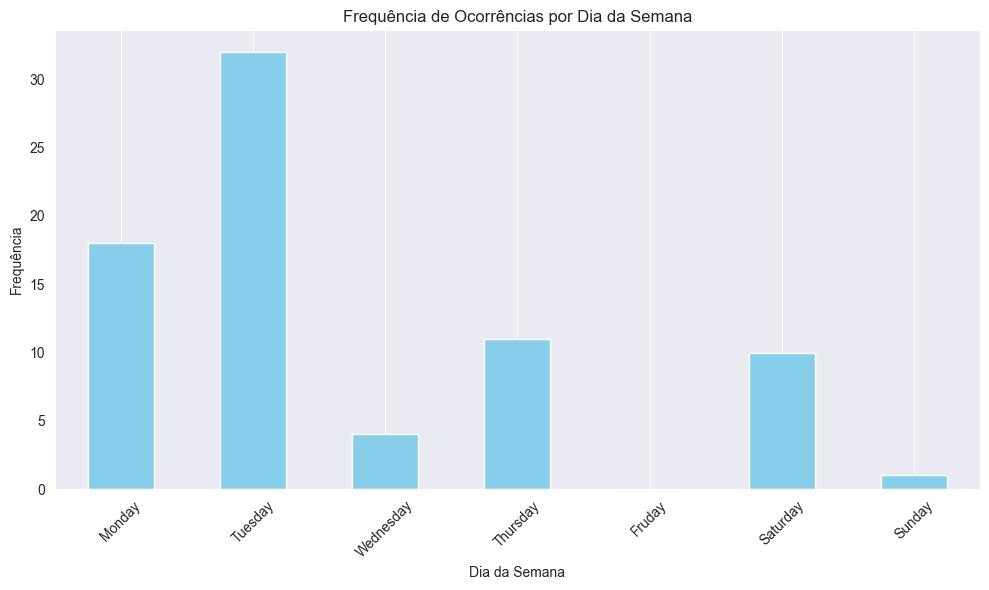

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Contar a frequência de cada dia da semana
frequencia_dias = gdf_sem_correspondencia['Dia da Semana'].value_counts()

# Reordenar o índice para que os dias da semana apareçam na ordem correta
dias_da_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Fruday', 'Saturday', 'Sunday']
frequencia_dias = frequencia_dias.reindex(dias_da_semana, fill_value=0)

# Gerar o histograma
plt.figure(figsize=(10, 6))
frequencia_dias.plot(kind='bar', color='skyblue')
plt.title('Frequência de Ocorrências por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Exibir o gráfico
plt.tight_layout()  # Ajustar layout
plt.show()

In [15]:
total_true = gdf_sem_correspondencia['Correspondencia'].sum()

# Contar o total de valores False
total_false = len(gdf_sem_correspondencia) - total_true

# Exibir os resultados
print(f"Total True: {total_true}")
print(f"Total False: {total_false}")

Total True: 0
Total False: 84


In [45]:
data_filtro='2013-11-07'

# Converta a string da data para o formato datetime (caso ainda não esteja nesse formato)
data_filtro = pd.to_datetime(data_filtro)

# Filtrar o GeoDataFrame para a data específica
gdf_filtrado = gdf_incidentes[gdf_incidentes['data'] == data_filtro]

# Exibir o resultado
print(gdf_filtrado)

          data  ocorrencia subprefeit   name  \
243 2013-11-07  ALAGAMENTO    SE - SE  41966   

                               geometry  Correspondencia  
243  POINT Z (331807.453 7395518.097 0)            False  


In [16]:
gdf_incidentes['data'].unique()

<DatetimeArray>
['2014-10-26 00:00:00', '2014-11-01 00:00:00', '2014-11-03 00:00:00',
 '2014-11-04 00:00:00', '2014-11-05 00:00:00', '2014-11-07 00:00:00',
 '2014-11-13 00:00:00', '2014-11-14 00:00:00', '2014-11-15 00:00:00',
 '2014-11-24 00:00:00', '2014-11-25 00:00:00', '2014-11-26 00:00:00',
 '2014-12-10 00:00:00', '2014-12-11 00:00:00', '2014-12-12 00:00:00',
 '2014-12-15 00:00:00', '2014-12-19 00:00:00', '2014-12-22 00:00:00',
 '2014-12-23 00:00:00', '2014-12-24 00:00:00', '2014-12-25 00:00:00',
 '2014-12-29 00:00:00', '2014-12-30 00:00:00', '2014-12-09 00:00:00',
 '2014-01-02 00:00:00', '2014-01-03 00:00:00', '2014-01-06 00:00:00',
 '2014-01-07 00:00:00', '2014-01-09 00:00:00', '2014-01-10 00:00:00',
 '2014-01-12 00:00:00', '2014-01-13 00:00:00', '2014-01-14 00:00:00',
 '2014-01-15 00:00:00', '2014-01-16 00:00:00', '2014-01-17 00:00:00',
 '2014-01-21 00:00:00', '2014-01-22 00:00:00', '2014-01-23 00:00:00',
 '2014-01-24 00:00:00', '2014-01-25 00:00:00', '2014-01-27 00:00:00',
 '20

### Preparação dos pacotes de simulação

In [138]:
# Função para ajustar horários sem ultrapassar os limites do dia
def ajustar_horarios(horario, ajuste, dia):
    try:
        # Convertendo o horário para datetime e aplicando o ajuste
        horario_dt = pd.to_datetime(horario, format='%H:%M:%S', errors='coerce')
        
        # Se o horário for inválido, gerar erro
#        if pd.isna(horario_dt):
#            raise ValueError(f"Formato de horário inválido: {horario}")
        
        # Verificar se o horário foi convertido corretamente
        if pd.isna(horario_dt):
            print(f"Formato de horário inválido: '{horario_dt}' na data {data}")
            return None  # Retorna None para horários inválidos
        
        # Combinar a data com o horário (para que ele carregue o dia correto)
        horario_completo = datetime.combine(pd.to_datetime(dia).date(), horario_dt.time())
        
        # Aplicar o ajuste de horas
        horario_ajustado = horario_completo + timedelta(hours=ajuste)
       
        # Aplicar o ajuste de horas
        #horario_ajustado = horario_dt + timedelta(hours=ajuste)
        #print(f'Função: horário original, {horario} e ajuste: {horario_ajustado}')
        
        # Garantir que a simulação comece e termine no mesmo dia
        inicio_dia = pd.to_datetime(f"{dia} 00:00:01")
        fim_dia = pd.to_datetime(f"{dia} 23:59:59")
        
        # Verificar se o horário ajustado ultrapassa os limites do dia
        if horario_ajustado < inicio_dia:
            #print(horario_ajustado, inicio_dia)
            horario_ajustado = inicio_dia
        elif horario_ajustado > fim_dia:
            horario_ajustado = fim_dia
        
        # Retorna apenas o horário ajustado
        #print(horario_ajustado)
        return horario_ajustado.time()
    
    except Exception as e:
        print(f"Erro ao ajustar horário: {e}")
        return None

In [139]:
from datetime import timedelta
    
# Parâmetros de ajuste
ajuste_inicio = -2  # Duas horas antes do horário inicial
ajuste_fim = 2  # Duas horas depois do horário final

# Lista de resultados para armazenar os dados de cada iteração
resultados = []

# Extraindo todas as datas únicas do gdf_incidentes
datas_unicas = gdf_incidentes['data'].dt.date.unique()

# Iterando sobre cada data única
for dia in datas_unicas:
    
    # Verificando se a data existe no df_cge
    if dia in df_cge['Data'].dt.date.unique():
        # Filtrando o DataFrame para a data específica
        df_filtrado = df_cge[df_cge['Data'].dt.date == dia]
        
        # Selecionando o horário mais cedo e o mais tarde
        horario_inicial = df_filtrado['Horário Inicial'].min()
        #print('Horário mais cedo: ', horario_inicial)
        horario_final = df_filtrado['Horário Final'].max()
        #print('Horário mais tarde: ', horario_final)
        
        # Calculando os horários de simulação ajustados
        simulacao_inicio = ajustar_horarios(horario_inicial, ajuste_inicio, dia)
        simulacao_final = ajustar_horarios(horario_final, ajuste_fim, dia)
        #print(f'Data mais cedo: {horario_inicial}, início da simulação: {simulacao_inicio}')
        
        # Adicionando as informações à lista de resultados
        resultados.append({
            'Data': dia,
            'Horário Inicial': horario_inicial,
            'Horário Final': horario_final,
            'Simulação Início': simulacao_inicio,
            'Simulação Final': simulacao_final,
            'Tipo': 'Detalhado'
        })
        
    else:
        # Caso a data não exista no df_cge, adicionar o dia inteiro
        horario_inicial = '00:00:00'
        horario_final = '23:59:59'
        
        # Calculando os horários de simulação ajustados
        simulacao_inicio = horario_inicial
        simulacao_final = horario_final
        
        resultados.append({
            'Data': dia,
            'Horário Inicial': horario_inicial,
            'Horário Final': horario_final,
            'Simulação Início': simulacao_inicio,
            'Simulação Final': simulacao_final,
            'Tipo': 'Inteiro'
        })

# Criando um DataFrame a partir da lista de resultados
novo_df = pd.DataFrame(resultados)

# Exibindo o DataFrame final
print(novo_df)

           Data Horário Inicial Horário Final Simulação Início  \
0    2015-12-27        01:44:00      18:43:00         00:00:01   
1    2015-12-26        18:51:00      23:44:00         16:51:00   
2    2015-12-29        01:07:00      23:06:00         00:00:01   
3    2015-12-30        00:05:00      22:52:00         00:00:01   
4    2015-12-20        15:28:00      22:20:00         13:28:00   
..          ...             ...           ...              ...   
116  2015-01-02        18:02:00      18:52:00         16:02:00   
117  2015-01-03        18:20:00      22:42:00         16:20:00   
118  2015-01-05        14:36:00      19:09:00         12:36:00   
119  2015-01-06        17:22:00      20:01:00         15:22:00   
120  2015-09-12        00:00:00      23:59:59         00:00:00   

    Simulação Final       Tipo  
0          20:43:00  Detalhado  
1          23:59:59  Detalhado  
2          23:59:59  Detalhado  
3          23:59:59  Detalhado  
4          23:59:59  Detalhado  
..       

In [147]:
# Filtrar o GeoDataFrame para a data específica
df_filtrado = novo_df[novo_df['Tipo'] == 'Detalhado']

# Exibir o resultado
print(df_filtrado)

           Data Horário Inicial Horário Final Simulação Início  \
0    2015-12-27        01:44:00      18:43:00         00:00:01   
1    2015-12-26        18:51:00      23:44:00         16:51:00   
2    2015-12-29        01:07:00      23:06:00         00:00:01   
3    2015-12-30        00:05:00      22:52:00         00:00:01   
4    2015-12-20        15:28:00      22:20:00         13:28:00   
..          ...             ...           ...              ...   
115  2015-01-01        18:52:00      20:35:00         16:52:00   
116  2015-01-02        18:02:00      18:52:00         16:02:00   
117  2015-01-03        18:20:00      22:42:00         16:20:00   
118  2015-01-05        14:36:00      19:09:00         12:36:00   
119  2015-01-06        17:22:00      20:01:00         15:22:00   

    Simulação Final       Tipo  
0          20:43:00  Detalhado  
1          23:59:59  Detalhado  
2          23:59:59  Detalhado  
3          23:59:59  Detalhado  
4          23:59:59  Detalhado  
..       

In [143]:
## Função para combinar data e hora (tratando strings e objetos time)
def combinar_data_hora(data_str, horario):
    data = pd.to_datetime(data_str)  # Converter string para datetime (apenas data)
    
    # Se o horário for string, converte para time, caso contrário, usa o time diretamente
    if isinstance(horario, str):
        horario = datetime.strptime(horario, '%H:%M').time()  # Converter string para time
    
    return datetime.combine(data.date(), horario)

# Aplicar a função para combinar a data com os horários
novo_df['Simulação Início Completo'] = novo_df.apply(lambda row: combinar_data_hora(row['Data'], row['Simulação Início']), axis=1)
novo_df['Simulação Final Completo'] = novo_df.apply(lambda row: combinar_data_hora(row['Data'], row['Simulação Final']), axis=1)

# Calcular a diferença em horas entre 'Simulação Início Completo' e 'Simulação Final Completo'
novo_df['Diferença em Horas'] = (novo_df['Simulação Final Completo'] - novo_df['Simulação Início Completo']).dt.total_seconds() / 3600

# Exibir o dataframe com a nova coluna
print(novo_df[['Simulação Início Completo', 'Simulação Final Completo', 'Diferença em Horas']])

ValueError: unconverted data remains: :00

In [146]:
#calculate time difference in hours
#df['hours_diff'] = (df.end_time - df.start_time) / pd.Timedelta(hours=1)

# Calcular a diferença em horas entre 'Simulação Início Completo' e 'Simulação Final Completo'
novo_df['Delta Horas'] = (novo_df['Simulação Final'] - novo_df['Simulação Início'])/pd.Timedelta(hours=1)

TypeError: unsupported operand type(s) for -: 'datetime.time' and 'datetime.time'